# Identfying health potions

The character has a belt with 10 slots, and each slot might contain a potion. There are three main types of potions, restoring their respective property:

- red health potions
- blue mana potions
- yellow rejuvation potions, restoring both values

All three types of potions have two sizes, small and big. Small potions restore only some of the property, while the big potions restore all.

Note: This workbook reuses some techniques from the OCR demonstration. The same solution will not be described again. Please check ocr_by_template_matching.ipynb before this one. 

## Scope

In this workbook we are going to show to analyse all the slots and determine:

- Which one has a health point in it?
- What kind of health potion is it, big or small?

## Load a screenshot and crop for the belt

The starting input a screenshot from the game. For the workbook we are using a static image, in the real program this is of course a stream of pictures many times a second.

The belt is always visible and always in the same place. Easy target for some cropping.

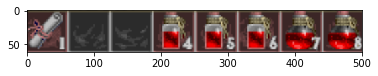

In [1]:
import cv2
# matplotlib only used to show these results in Jupyter. It is not part of the actual solution.
%matplotlib inline
from matplotlib import pyplot as plt

# Importing tools needed for interactivity
import ipywidgets as widgets
from ipywidgets import interact, interact_manual


screenshot = cv2.imread("../tests/test_data/character_screen_1440_0.PNG")
# This conversion only needed for Jupyter. OpenCV is BGR by default, while matplotlib is RGB.
screenshot = cv2.cvtColor(screenshot,cv2.COLOR_BGR2RGB)

width = screenshot.shape[1]
height = screenshot.shape[0]

# These are constants, we know the relative location
x_start_rel = 450/1400
x_size_rel = 500/1400
y_start_rel = 780/1050
y_size_rel = 62.5/1050

# Based on the actual resolution now we know the pixel perfect coordinates we need
x_start_abs = int(x_start_rel * width)
x_size_abs = int(x_size_rel * width)
y_start_abs = int(y_start_rel * height)
y_size_abs = int(y_size_rel * height)

belt = screenshot[y_start_abs:y_start_abs + y_size_abs, x_start_abs:x_start_abs+x_size_abs]
plt.imshow(belt)


## Crop for each item

We know the total size of the belt in pixels, and also know it always contains 8 items. Now it is easy to separate the items in it.

In the example only the last item (index 7) is show. Putting there all images is not practical in Jupyter, but we already believe it works. :)

In [2]:
slot_icons=[]
width_of_item=63
print(width_of_item)
for i in range(0,8):
   slot_icons.append(belt[0:y_size_abs, i*width_of_item:i*width_of_item+width_of_item])

def f(x):
    plt.imshow(slot_icons[x])

interact(f,x=(0,7))

63


interactive(children=(IntSlider(value=3, description='x', max=7), Output()), _dom_classes=('widget-interact',)…

<function __main__.f(x)>

## Finding health potions

Let's attack the picture with some simple colored filters, see what happens.
The picture is current in RGB. We set up a filter for the red color, allowing some low levels of blue and green.

Based on our small sample this looks like a possible way to go.

In [3]:
def filter_belt(red_filter,green_filter,blue_filter):
    belt_redfiltered = cv2.inRange(belt, (0,0,0), (red_filter,green_filter,blue_filter))
    plt.imshow(belt_redfiltered)

interact(filter_belt,red_filter=(0,255), green_filter=(0,255), blue_filter=(0,255))

interactive(children=(IntSlider(value=127, description='red_filter', max=255), IntSlider(value=127, descriptio…

<function __main__.filter_belt(red_filter, green_filter, blue_filter)>

Based on experience of fiddling around __the filter of (255,30,30)__ seems good enough.

In [4]:
filtered_icons=[]
for i in range(0,8):
    filtered_icons.append(cv2.inRange(slot_icons[i], (0,0,0), (255,30,30)) )
    
def show_filtered_slot(x):
    plt.imshow(filtered_icons[x])

interact(show_filtered_slot,x=(0,7))

interactive(children=(IntSlider(value=3, description='x', max=7), Output()), _dom_classes=('widget-interact',)…

<function __main__.show_filtered_slot(x)>

Based on this information, whether there is anything on the screen, we should be able to tell where is there a heath potion.
At this point we are assuming we successfully filtered for the potions. ( based on our small example this looks allright)
Now review each slot, and determine if any information is in them after filtering. If yes, it is a potion, if no, not a potion.

In [5]:
potion_or_not=[]

for i in range(0,8):
    red_filtered_slot = cv2.inRange(slot_icons[i], (0,0,0), (255,30,30)) 
    total_information = cv2.countNonZero(red_filtered_slot)
    potion_or_not.append(1 if total_information else 0)

print(potion_or_not)

[0, 0, 0, 1, 1, 1, 1, 1]


The pattern is **0,0,0,1,1,1,1,1**

Now we have the pattern of where is a health potion, and where not. Great.
Just for easy verification here is the original picture again:

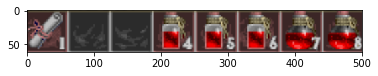

In [6]:
plt.imshow(belt)

## Small or large health potion

After filtering the bigger potions seem to have more white pixels in them, they are bigger afterall. For the next step we will measure the 
Let's check the total number of white pixels in a big potion.

In [7]:
print(cv2.countNonZero(filtered_icons[7]))

822


822, nice. Now check the small potion, and hope it is significantly different so we can use that information for decision.

In [8]:
def summarize_slot(x):
    print(cv2.countNonZero(filtered_icons[x]))
    plt.imshow(filtered_icons[x])

interact(summarize_slot,x=(0,7))

interactive(children=(IntSlider(value=3, description='x', max=7), Output()), _dom_classes=('widget-interact',)…

<function __main__.summarize_slot(x)>

- Heavy potions: ~822
- Small potions: ~464

Based on these values we are choosing **650** as a good middle ground, as thresholding limit to decide if a potion is big or small.

## Reconstruct the data in digital form

Putting it all together, lets create an array where:
i. value describes the i. slot in the belt, starting from left to right.

- **0** = not a health potion
- **1** = small health potion
- **2** = great health potion

In the following example we can see each slot with it's corresponding type:

In [9]:
def identify_slot(x):
    red_filtered_slot = cv2.inRange(slot_icons[x], (0,0,0), (255,30,30)) 
    total_information = cv2.countNonZero(red_filtered_slot)
    if total_information > 650 :
        slot_type = 2
    elif total_information > 420 :
        slot_type = 1 
    else:
        slot_type = 0
    print(slot_type)
    plt.imshow(slot_icons[x])


interact(identify_slot,x=(0,7))

interactive(children=(IntSlider(value=3, description='x', max=7), Output()), _dom_classes=('widget-interact',)…

<function __main__.identify_slot(x)>

And as a summary here we create an array of all the types to demonstrate the required behaviour:

In [10]:
potions_in_belt=[]

for i in range(0,8):
    red_filtered_slot = cv2.inRange(slot_icons[i], (0,0,0), (255,30,30)) 
    total_information = cv2.countNonZero(red_filtered_slot)
    if total_information > 650 :
        potions_in_belt.append(2)
    elif total_information > 420 :
        potions_in_belt.append(1)
    else:
        potions_in_belt.append(0)

print(potions_in_belt)

[0, 0, 0, 1, 1, 1, 2, 2]


## Success

The pattern is **0,0,0,1,1,1,2,2**

We can quickly verify this is correct based on our picture:

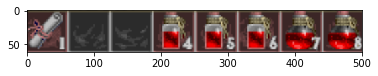

In [11]:
plt.imshow(belt)